# M2 DAC - 2023/2024 - AMAL PROJECT
# ICLR 2024 - Towards Batch Normalization Without Gradient Explosion
### Authors of paper : Alexandru METEREZ, Amir JOUDAKI, Francesco ORABONA, Alexander IMMER, Gunnar RATSCH, Hadi DANESHMAND

### Notebook by: Allaa BOUTALEB, Samy NEHLIL & Ghiles OUHENIA 

This notebook contains the necessary code to reproduce the train/test accuracy figure.

**Useful information**: 

- The main train loop takes excruciatingly long for parameter combinations of very deep MLPs (1000 layers).
- Checkpointing at every epoch has been implemented to allow the interruption of the train loop at any moment.
- The training will pick up right where it left off when executing the loop again.
- After the training is completed for a parameter combination, train/test accuracy results will be saved in the form of a .csv file. 

In [1]:
# Standard library imports
import os
import sys
sys.path.append("..")

# Third-party imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Local imports
from src.model import MLPWithBatchNorm
from src.utils import train_one_epoch, test_one_epoch, TensorDataLoader, dataset_to_tensors
from src.constants import *



In [2]:
# Possible choices : ['MNIST', 'CIFAR10', 'CIFAR100', 'FashionMNIST']
DATASET = 'MNIST'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initial Setup configuration

In [3]:
config = {
    ############# Dataset configuration #############
    'dataset_name': DATASET,  # Assuming DATASET is predefined, can be ['MNIST', 'CIFAR10', 'CIFAR100', 'FashionMNIST']
    'batch_size': 100,  # Batch size for training and evaluation, MAKE SURE batch_size = hidden_dim

    ############# Model architecture parameters #############
    'num_layers': None,  # Number of layers, TBD
    'hidden_dim': 100,  # Dimension of hidden layers in the network, MAKE SURE batch_size = hidden_dim
    'norm_type': 'torch_bn',  # Normalization type, using PyTorch's built-in BatchNorm
    'activation': None,  # Activation function, TBD
    'bias': True,  # Whether to use bias in fully connected layers
    'order': 'norm_act',  # Order of applying normalization and activation
    
    ############# Initialization and normalization parameters #############
    'init_type': None,  # Weights Initialization method, TBD
    'mean_reduction': False,  # Applicable only for custom normalization, not needed for torch_bn
    'force_factor': None,  # Applicable only for custom normalization, not needed for torch_bn
    'gain_exponent': -0.4,  # Exponent for gain adjustment
    
    ############# Training parameters #############
    'learning_rate': 0.001,  # Learning rate for optimizer
    'num_epochs': 200,  # Number of epochs for training
}     

# Loading dataset

Datasets are loaded via a custom DataLoader, combining torch's DataLoader and TensorDataset for efficient batch sampling and adaptive augmentation on GPU.

In [5]:
ds = getattr(torchvision.datasets, config['dataset_name'])
trainset = ds(root='Data/', train=True, download=True, transform=DS_TRANSFORMS[DATASET])
testset = ds(root='Data/', train=False, download=True, transform=DS_TRANSFORMS[DATASET])

trainloader = TensorDataLoader(*dataset_to_tensors(trainset, device=device), batch_size=config['batch_size'], shuffle=True)
testloader = TensorDataLoader(*dataset_to_tensors(testset, device=device), batch_size=config['batch_size'], shuffle=False)

# Main Training loop 
Checkpointing is done every epoch. You can interrupt the loop anytime and it'll pick up right where it left off.

In [6]:
# Completing Configuration setup for training
combinations = [
    # DEPTH 100
    ('orthogonal', 100, 'identity'),
    ('orthogonal', 100, 'tanh'),
    ('orthogonal', 100, 'sin'),
    ('orthogonal', 100, 'relu'),

    # DEPTH 500
    ('orthogonal', 500, 'identity'),
    ('orthogonal', 500, 'tanh'),
    ('orthogonal', 500, 'sin'),

    # DEPTH 1000
    ('orthogonal', 1000, 'tanh'),
    ('orthogonal', 1000, 'identity'),
    ('orthogonal', 1000, 'sin'),
]

# Directories for saving training results and checkpoints
save_path = 'training/results/'
checkpoint_path = 'training/checkpoints/'

# Ensure the directories exist
os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

In [ ]:
for init_type, num_layers, activation in combinations:
    # Update the config dictionary with the current combination
    config['init_type'] = init_type
    config['num_layers'] = num_layers
    config['activation'] = activation

    # Instantiate the model with the updated configuration
    model = MLPWithBatchNorm(
        input_dim=DS_INPUT_SIZES[DATASET],
        output_dim=DS_NUM_CLASSES[DATASET], 
        num_layers=config['num_layers'],
        hidden_dim=config['hidden_dim'],
        norm_type=config['norm_type'],
        mean_reduction=config['mean_reduction'],
        activation=ACTIVATIONS[config['activation']],
        save_hidden=False,
        exponent=config['gain_exponent'],
        order=config['order'],
        force_factor=config['force_factor'],
        bias=config['bias']
    ).to(device)
    
    # Initialize model parameters
    model.reset_parameters(config['init_type'], gain=GAINS[activation])

    # Setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])
    
    # Initialize training starting epoch and results DataFrame
    start_epoch = 1
    df = []
    
    # Checkpoint file path
    checkpoint_file = os.path.join(checkpoint_path, f'checkpoint_d{num_layers}_{activation}_{init_type}.pt')

    # Load checkpoint if it exists
    if os.path.isfile(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        df = checkpoint['df']

    # Training loop
    progress_bar = tqdm(range(start_epoch, config['num_epochs'] + 1), desc="Training")
    for epoch in progress_bar:
        # Perform training and evaluation for one epoch
        train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device)
        test_loss, test_acc = test_one_epoch(model, testloader, criterion, device)
        
        # Record the metrics for this epoch
        df.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
        })
        
        # Update progress bar with latest metrics
        progress_bar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


        # Save checkpoint after every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'df': df,
        }, checkpoint_file)

    # Save the final results to CSV
    results_df = pd.DataFrame(df)
    save_name = DATASET+f'_d{num_layers}_{activation}_{init_type}.csv'
    results_df.to_csv(os.path.join(save_path, save_name))

# Visualization of results

RESULTS FOR MNIST DATASET


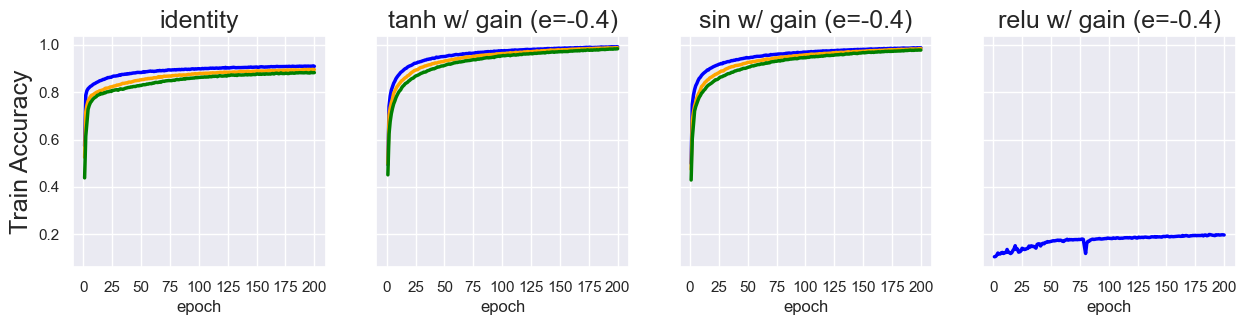

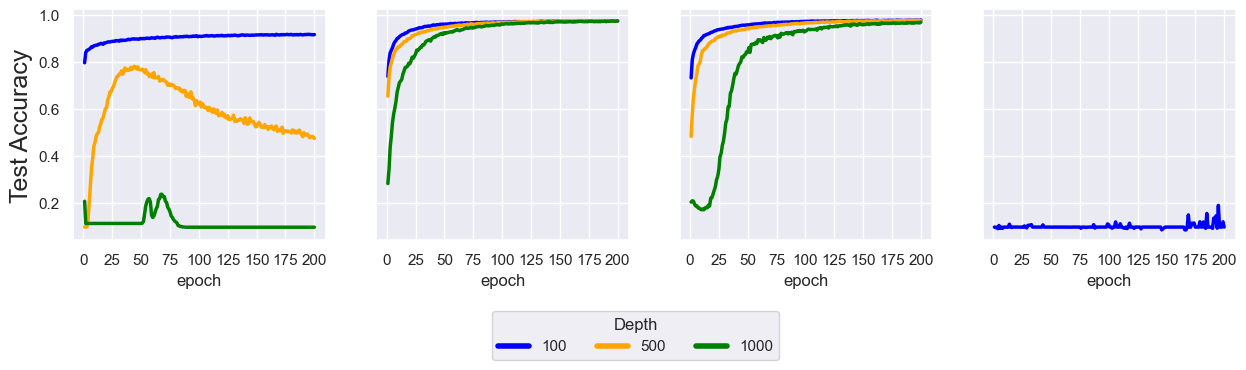

In [12]:
# Define file names
files = {
    "identity": [
        DATASET+"_d100_identity_orthogonal.csv",
        DATASET+"_d500_identity_orthogonal.csv",
        DATASET+"_d1000_identity_orthogonal.csv"
    ],
    "tanh": [
        DATASET+"_d100_tanh_orthogonal.csv",
        DATASET+"_d500_tanh_orthogonal.csv",
        DATASET+"_d1000_tanh_orthogonal.csv"
    ],
    "sin": [
        DATASET+"_d100_sin_orthogonal.csv",
        DATASET+"_d500_sin_orthogonal.csv",
        DATASET+"_d1000_sin_orthogonal.csv"
    ],
    "relu": [
        DATASET+"_d100_relu_orthogonal.csv"
    ]
}
# Set the aesthetic style of the plots
sns.set(style="darkgrid")

# Increase the overall font size
plt.rcParams.update({'font.size': 14})

save_path = 'training/results/'


# Initialize the figure for train accuracy
fig_train, axes_train = plt.subplots(1, 4, figsize=(15, 3), sharey=True)

# Initialize the figure for test accuracy
fig_test, axes_test = plt.subplots(1, 4, figsize=(15, 3), sharey=True)

# Custom colors for depth
colors = ['blue', 'orange', 'green']
depth_labels = ['100', '500', '1000']

# Loop through each activation function and its corresponding files
for idx, (activation, file_list) in enumerate(files.items()):
    for file_idx, file in enumerate(file_list):
        # Load data
        df = pd.read_csv(save_path + f"/{file}")
        
        # Filter out epochs greater than 200 and remove duplicate epochs
        df = df[df['epoch'] <= 200].drop_duplicates(subset='epoch')

        # Plot train accuracy
        sns.lineplot(ax=axes_train[idx], x=df['epoch'], y=df['train_acc'], color=colors[file_idx], linewidth=2.5)
        axes_train[idx].set_xticks(range(0, 201, 25))
        axes_train[idx].set_ylabel("Train Accuracy", fontsize=18)

        if idx!=0: axes_train[idx].set_title(f"{activation} w/ gain (e={config['gain_exponent']})", fontsize=18)
        else: axes_train[idx].set_title(f"{activation}", fontsize=18)

        # Plot test accuracy
        sns.lineplot(ax=axes_test[idx], x=df['epoch'], y=df['test_acc'], color=colors[file_idx], linewidth=2.5)
        axes_test[idx].set_xticks(range(0, 201, 25))
        axes_test[idx].set_ylabel("Test Accuracy", fontsize=18)



# Create a common legend for depth
custom_lines = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]

# Adjusting legends and applying tight layout for test figure
fig_test.legend(custom_lines, depth_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title='Depth')

# Save the figures
fig_train.savefig("Figures/train_accuracy_figure.pdf", bbox_inches='tight')
fig_test.savefig("Figures/test_accuracy_figure.pdf", bbox_inches='tight')


print("RESULTS FOR "+DATASET+" DATASET")

